# Building confidence ellipses (in meters) for PyMC3 algorithm
### **Reference system origin: Seismic station (0, 0)**

#### In the following code we will start building the confidence ellipses for our PyMC3 code. We only need the file **data/6_clusters/catalog_with_clusters_ids.csv** resulted from ConvNetQuake.

###### The *catalog_with_clusters_ids.csv* file is obtained afer run:
**./bin/preprocess/cluster_events.ridgcrest --src data/catalogs/Ridgecrest_filtrado.csv --dst data/6_clusters --n_components 6 --model KMeans**

In [1]:
#Importing libraries
import csv
import os
import pandas as pd
from pyproj import Proj, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

##### The original catalog is in decimal degrees (EPSG:4326). We need to transform this initial coordinate system to EPSG:26711, which is in meters and corresponds to the adequate projection system for our area of study. Moreover, it is neccessary to adjust the coordinate (0,0) to a relative reference system (centered at the station).

In [2]:
# Define the original coordinate system (latitude, longitude)
wgs84 = Proj(init='epsg:4326')

# Define the target coordinate system (UTM in Zone 11, northern hemisphere, NAD27)
utm_nad27 = Proj(init='epsg:26711')

# We need to transform the coordinates of the station as a special case (we will need to know for the plot)
station_latitude = 35.81574    # latitude of CI.CLC
station_longitude = -117.59751    #Longitude of CI.CLC
                         
# Transform coordinates of the station point to UTM in Zone 11, northern hemisphere, NAD27
ref_x, ref_y = transform(wgs84, utm_nad27, station_longitude, station_latitude)

# Read data from the CSV file
csv_file = '../CONVN/data/6_clusters/catalog_with_cluster_ids.csv'
data = pd.read_csv(csv_file)

# Transform all coordinates to the target coordinate system
data['longitude_UTM'], data['latitude_UTM'] = transform(wgs84, utm_nad27, data['longitude'].values, data['latitude'].values)

# Subtract coordinates of the reference point (station) to set it as the origin
data['longitude_UTM'] -= ref_x
data['latitude_UTM'] -= ref_y

# Print some rows of the resulting DataFrame
# print(data.head())

# Save the transformed data to a new CSV file
output_file = '../CONVN/data/6_clusters/catalog_with_cluster_ids_meters_2D_STA.csv'
data.to_csv(output_file, index=False)


/opt/miniforge3/envs/eqt/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/miniforge3/envs/eqt/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_66987/725461796.py:12: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ref_x, ref_y = trans

In [3]:
# Define the path of the .csv file
file_path = '../CONVN/data/6_clusters/catalog_with_cluster_ids_meters_2D_STA.csv'

# Create a dictionary to store data for each cluster_id
data_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []}

# Read the .csv file and split the data into the dictionary based on cluster_id
with open(file_path, 'r') as file:
    csv_reader = csv.reader(file)
    headers = next(csv_reader)  # Read the file header
    for row in csv_reader:
        cluster_id = int(row[2])
        data_dict[cluster_id].append(row)

# Create a directory to store the files
output_dir = '../CONVN/data/6_clusters/csv_clusters/2D_STA'
os.makedirs(output_dir, exist_ok=True)

# Write the data to separate files based on cluster_id
for cluster_id, rows in data_dict.items():
    cluster_file_path = os.path.join(output_dir, f'cluster_{cluster_id}_meters.csv')
    with open(cluster_file_path, 'w', newline='') as cluster_file:
        csv_writer = csv.writer(cluster_file)
        csv_writer.writerow(headers)  # Write the header
        csv_writer.writerows(rows)

print("Separate files created successfully.")


Separate files created successfully.


##### Next, we will build the confidence ellipses for each *cluster_id* and plot the ellipses.

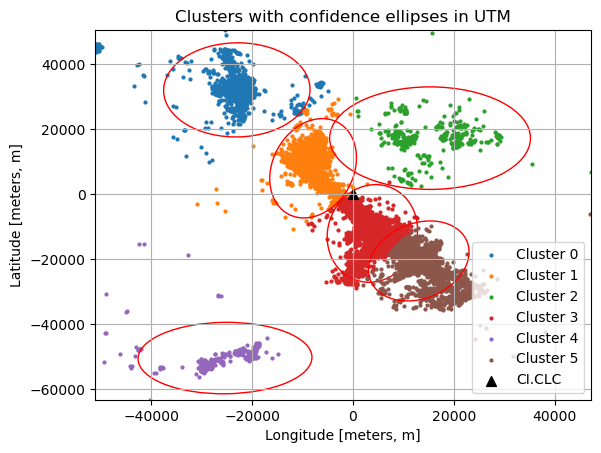

In [4]:
# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Calculate the angle of the ellipse
    theta = 0.5 * np.arctan(2 * pearson * cov[0, 1] / (cov[0, 0] - cov[1, 1]))
    # Calculate the axes of the ellipse
    width, height = 2 * n_std * np.sqrt(cov[0, 0]), 2 * n_std * np.sqrt(cov[1, 1])
    ellipse = Ellipse((np.mean(x), np.mean(y)), width, height, angle=180 * theta / np.pi, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

# Create a figure and a single set of axes
fig, ax = plt.subplots()

# Define initial bounds
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

# Iterate over CSV files and display ellipses and points on the same figure
for i in range(6):
    # Read the CSV file
    data = pd.read_csv(f'../CONVN/data/6_clusters/csv_clusters/2D_STA/cluster_{i}_meters.csv')

    # Extract columns of longitude and latitude
    x = data['longitude_UTM']  # Make sure to put the correct column name
    y = data['latitude_UTM']  # Make sure to put the correct column name

    # Calculate mean and covariance matrix
    mu = np.mean(x), np.mean(y)
    cov = np.cov(x, y)

    # Plot data points and confidence ellipse on the same figure
    ax.scatter(x, y, s=4, label=f'Cluster {i}')
    confidence_ellipse(x, y, ax, edgecolor='red')

    # Update bounds
    x_min, x_max = min(x_min, min(x)), max(x_max, max(x))
    y_min, y_max = min(y_min, min(y)), max(y_max, max(y))

# Adjust axis bounds with a small margin
padding = 0.05
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

# Add station point (0, 0)
ax.scatter(0, 0, marker="^", color='black', s=50, label='CI.CLC')

# Uncomment if you want to plot event location results
#ax.scatter(5087.494, 5466.761, marker="s", color='black', s=40, label='Event A')
#ax.scatter(4529.634, 5011.558, marker="*", color='black', s=50, label='Event B')
#ax.scatter(5364.338, 4670.152, marker="X", color='black', s=50, label='Event C')

# Add labels to axes and title
ax.set_xlabel('Longitude [meters, m]')
ax.set_ylabel('Latitude [meters, m]')
ax.set_title('Clusters with confidence ellipses in UTM')

# Add legend in the lower-right corner and save the reference in a variable
legend = ax.legend(loc='lower right')

# Save the plot in PNG format and make sure the legend is included
plt.grid(True)
plt.savefig('../CONVN/data/6_clusters/confidence_ellipses_ridgecrest_meters_2D_STA.png', format='png', bbox_inches='tight', bbox_extra_artists=[legend])

# Show the figure
plt.show()


##### Finally we will obtain the confidence ellipses information.

In [5]:
# Iterate over CSV files
for i in range(6):
    # Read the CSV file
    data = pd.read_csv(f'../CONVN/data/6_clusters/csv_clusters/2D_STA/cluster_{i}_meters.csv')

    # Extract columns of longitude and latitude
    x = data['longitude_UTM']
    y = data['latitude_UTM']

    # Calculate mean and covariance matrix
    mu = np.mean(x), np.mean(y)
    cov = np.cov(x, y)

    # Check if the covariance matrix is singular and, if necessary, regularize
    if np.linalg.det(cov) == 0:
        cov += 1e-10 * np.eye(2)  # Add a small amount to the diagonal to regularize

    # Calculate eigenvectors and eigenvalues
    eigvals, eigvecs = np.linalg.eig(cov)

    # Calculate orientation in degrees
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    theta = 0.5 * np.arctan(2 * pearson * cov[0, 1] / (cov[0, 0] - cov[1, 1]))
    orientation_degrees = 180 * theta / np.pi

    # Calculate standard deviations
    std_dev_x = np.sqrt(cov[0, 0])
    std_dev_y = np.sqrt(cov[1, 1])

    # Calculate 95% confidence ellipse
    confidence_level = 0.95
    rv = multivariate_normal(mean=mu, cov=cov)
    ell_radius_x = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_x
    ell_radius_y = np.sqrt(-2 * np.log(1 - confidence_level)) * std_dev_y

    # Calculate eccentricity using Singular Value Decomposition (SVD)
    _, s, _ = np.linalg.svd(cov)
    eccentricity = np.sqrt(1 - (np.min(s) / np.max(s))**2)

    # Print information
    print(f"\nCluster {i}:\n")
    print("Mean:", mu)
    print("Covariance matrix:\n", cov)
    print("Eigenvalues:", eigvals)
    print("Eigenvectors:\n", eigvecs)
    print("Orientation (degrees):", orientation_degrees)
    print("Standard deviation in x:", std_dev_x)
    print("Standard deviation in y:", std_dev_y)
    print(f"Ellipse radius at {confidence_level * 100}% confidence:")
    print("In x:", ell_radius_x)
    print("In y:", ell_radius_y)
    print("Eccentricity:", eccentricity)
    print("\n---\n")


Cluster 0:

Mean: (-23041.166265774566, 32044.48603132775)
Covariance matrix:
 [[23683275.01936196 -7482454.36868832]
 [-7482454.36868832 23076283.80724357]]
Eigenvalues: [30868386.29057975 15891172.53602578]
Eigenvectors:
 [[ 0.72129316  0.6926299 ]
 [-0.6926299   0.72129316]]
Orientation (degrees): 41.38879740000602
Standard deviation in x: 4866.5465187709815
Standard deviation in y: 4803.778076393994
Ellipse radius at 95.0% confidence:
In x: 11912.073817682429
In y: 11758.432561787386
Eccentricity: 0.8573078296812892

---


Cluster 1:

Mean: (-7915.131452346466, 7907.0157733109045)
Covariance matrix:
 [[ 7693375.19143287 -6823906.54539936]
 [-6823906.54539936 26516441.70716951]]
Eigenvalues: [ 5479820.9741763  28729995.92442608]
Eigenvectors:
 [[-0.95120665  0.30855456]
 [-0.30855456 -0.95120665]]
Orientation (degrees): -9.553283454143656
Standard deviation in x: 2773.693420591553
Standard deviation in y: 5149.411782637849
Ellipse radius at 95.0% confidence:
In x: 6789.299279533206

##### The only information we will need for the PyMC3 algorithm are the *2D covariance matrices* and the *bivariate mean* for each one of the ellipses.